# Natural Statistics Cross-linguistic

Random samples contingency variable generation.

In [9]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, "data_proc")
import contingent_extraction
import warnings
warnings.filterwarnings('ignore')

In [10]:
rand_dat = pd.read_csv("../data/rand_dat.csv",index_col=0, low_memory=False)

In [11]:
# rand_dat.head()

----

#### How many languages are we analyzing?

In [12]:
rand_dat["language"].unique() # list of all langauges across corpora
int_rand_dat = rand_dat[~rand_dat["language"].str.contains("eng")]
int_rand_dat["language"].unique() # list of all languages that don't contain `eng` in language name
len(int_rand_dat["language"].unique()) # language count

15

15 languages + 1 (`eng`) - 1 (`por swe`). Thus, **15 langauges**! `por swe` (Portugese and Swedish) is removed because we will only analyze monolingual corpora first.

----

#### How many participants are we analyzing?

Get only monolingual corpora to finalize rand_dat dataframe.

In [13]:
eng_rand_dat = rand_dat[rand_dat["language"]=="eng"] # only english
rand_dat_inc = pd.concat([eng_rand_dat, int_rand_dat]) # english and non-english
rand_dat_inc = rand_dat_inc[rand_dat_inc["language"]!= "por swe"]# exclude bilingual (por swe)

In [14]:
rand_dat_inc=rand_dat_inc[rand_dat_inc["language"]!="ara"]
rand_dat_inc=rand_dat_inc[(rand_dat_inc["target_child_age"]>=5) & (rand_dat_inc["target_child_age"]<=30)]# exclude under 5- and over 30-month-olds

----
#### Transcript cleanse

In [15]:
#
# create 'caregiver' column
#
# add to this to include more speakers in "caregiver" category
#

conditions = [
    (rand_dat_inc["speaker_role"]=="Mother") | (rand_dat_inc["speaker_role"]=="Father"),
    (rand_dat_inc["speaker_role"]=="Target_Child")]

choices = ['caregiver', 'target_child']

rand_dat_inc['caregiver'] = np.select(conditions, choices, default='other')

# drop utterances where transcript = NaN
rand_dat_inc = rand_dat_inc.drop(rand_dat_inc[(rand_dat_inc['caregiver'] == 'caregiver') &
                                              (rand_dat_inc['gloss'].isna())].index)

In [16]:
# create language_name column

language_labels = pd.read_csv("../data/language_labels.csv")

language_labels=language_labels.rename(columns={"Language":"language"})

rand_dat_inc=rand_dat_inc.merge(language_labels,on='language',how="right")


In [19]:
# how many caregiver utterances per caregiver
cg_utt_counts = rand_dat_inc.groupby(['Language_name','transcript_id','caregiver']).size().unstack(fill_value=0).reset_index()

# how many transcripts with less than 5 caregiver utterances
cg_utt_counts = cg_utt_counts[cg_utt_counts['caregiver'] < 5]
# print(cg_utt_counts.to_markdown())

|      | Language_name   |   transcript_id |   caregiver |   other |   target_child |
|-----:|:----------------|----------------:|------------:|--------:|---------------:|
|   57 | Croatian        |           29287 |           0 |     161 |            117 |
|   72 | English         |            4182 |           3 |       0 |            136 |
|  146 | English         |            6987 |           0 |      69 |             38 |
|  147 | English         |            6989 |           0 |      93 |             87 |
|  148 | English         |            6990 |           0 |      88 |             66 |
|  150 | English         |            6992 |           0 |      73 |             53 |
|  153 | English         |            6996 |           0 |      65 |             61 |
|  154 | English         |            7000 |           0 |      96 |             68 |
|  245 | English         |            8480 |           0 |       0 |             76 |
|  246 | English         |            8482 |          

In [20]:
# drop transcripts with less than 5 caregiver utterances
cg_excluders = list(cg_utt_counts["transcript_id"])

rand_dat_inc = rand_dat_inc[~rand_dat_inc['transcript_id'].isin(cg_excluders)]

In [22]:
# how many target child utterances per transcript
tc_utt_counts = rand_dat_inc.groupby(['Language_name','transcript_id','caregiver']).size().unstack(fill_value=0).reset_index()
tc_utt_counts = tc_utt_counts[tc_utt_counts['target_child'] < 5]
print(tc_utt_counts.to_markdown())

|      | Language_name   |   transcript_id |   caregiver |   other |   target_child |
|-----:|:----------------|----------------:|------------:|--------:|---------------:|
|   44 | Croatian        |           29248 |          10 |       0 |              3 |
|   59 | English         |            3719 |         122 |       0 |              0 |
|   60 | English         |            3726 |          93 |       0 |              1 |
|   61 | English         |            3736 |         184 |       0 |              0 |
|  122 | English         |            4568 |         107 |       0 |              1 |
|  160 | English         |            8276 |         182 |       0 |              3 |
|  167 | English         |            8286 |         134 |       0 |              3 |
|  169 | English         |            8289 |         129 |       0 |              2 |
|  171 | English         |            8291 |          52 |       0 |              3 |
|  176 | English         |            8304 |         1

In [23]:
# drop transcripts with less than 5 target child utterances
tc_excluders = list(tc_utt_counts["transcript_id"])

rand_dat_inc = rand_dat_inc[~rand_dat_inc['transcript_id'].isin(tc_excluders)]

In [24]:
print("There are", 
      len(rand_dat_inc["language"].unique()),
      "different monolingual languages in this dataset.")

print("There are",
      len(rand_dat_inc["target_child_id"].unique()),
      "infants in this dataset.")

print("There are",
      len(rand_dat_inc["transcript_id"].unique()),
      "different transcripts in this dataset")

There are 14 different monolingual languages in this dataset.
There are 436 infants in this dataset.
There are 1578 different transcripts in this dataset


In [25]:
# how many children per language
child_counts = rand_dat_inc.groupby(['language','target_child_id']).nunique()
count_table = child_counts.groupby(['language']).size().to_frame('count').reset_index()
print(count_table.to_markdown())

|    | language   |   count |
|---:|:-----------|--------:|
|  0 | deu        |       4 |
|  1 | eng        |     387 |
|  2 | est        |       3 |
|  3 | fas        |       1 |
|  4 | fra        |      16 |
|  5 | hrv        |       3 |
|  6 | jpn        |       9 |
|  7 | kor        |       1 |
|  8 | nor        |       2 |
|  9 | pol        |       1 |
| 10 | por        |       2 |
| 11 | spa        |       3 |
| 12 | swe        |       3 |
| 13 | zho        |       1 |


In [27]:
# how many transcripts per language
transcript_counts = rand_dat_inc.groupby(['Language_name','transcript_id']).nunique()
count_table = transcript_counts.groupby(['Language_name']).size().to_frame('count').reset_index()
print(count_table.to_markdown())

|    | Language_name   |   count |
|---:|:----------------|--------:|
|  0 | Croatian        |      58 |
|  1 | English         |     882 |
|  2 | Estonian        |      22 |
|  3 | French          |     279 |
|  4 | German          |      38 |
|  5 | Japanese        |     160 |
|  6 | Korean          |      28 |
|  7 | Mandarin        |       2 |
|  8 | Norwegian       |      28 |
|  9 | Persian         |      11 |
| 10 | Polish          |       1 |
| 11 | Portuguese      |      23 |
| 12 | Spanish         |      30 |
| 13 | Swedish         |      16 |


In [28]:
# how many transcripts per language
transcript_x_child_counts = rand_dat_inc.groupby(['language','transcript_id','target_child_id']).nunique()
transcript_x_child_count_table = transcript_x_child_counts.groupby(['language','target_child_id']).size().to_frame('count').reset_index()
# print(transcript_x_child_count_table.to_markdown())

In [29]:
# how many corpora
corpora = pd.DataFrame(rand_dat_inc["corpus_name"].unique())
print(corpora.to_markdown())

|    | 0            |
|---:|:-------------|
|  0 | Leo          |
|  1 | Rigol        |
|  2 | Peters       |
|  3 | Rollins      |
|  4 | Bloom        |
|  5 | Brent        |
|  6 | Nelson       |
|  7 | Braunwald    |
|  8 | Soderstrom   |
|  9 | Sachs        |
| 10 | McCune       |
| 11 | NewmanRatner |
| 12 | MacWhinney   |
| 13 | Providence   |
| 14 | Argus        |
| 15 | Zupping      |
| 16 | Family       |
| 17 | York         |
| 18 | Lyon         |
| 19 | Yamaguchi    |
| 20 | Paris        |
| 21 | Hunkeler     |
| 22 | Kovacevic    |
| 23 | Ishii        |
| 24 | MiiPro       |
| 25 | Miyata       |
| 26 | Ryu          |
| 27 | Garmann      |
| 28 | WeistJarosz  |
| 29 | Santos       |
| 30 | Nieva        |
| 31 | Remedi       |
| 32 | Lund         |
| 33 | Andren       |
| 34 | Tong         |


In [30]:
# how many corpora with language names

corpora_langs = rand_dat_inc.groupby(['Language_name','corpus_name']).agg(['unique']).reset_index()
corpora_langs = corpora_langs.iloc[:, 0:2]
corpora_langs.columns.values[0] = "Language_name"
corpora_langs.columns.values[1] = "corpus_name"

print(corpora_langs.to_markdown())

|    | Language_name   | corpus_name   |
|---:|:----------------|:--------------|
|  0 | Croatian        | Kovacevic     |
|  1 | English         | Bloom         |
|  2 | English         | Braunwald     |
|  3 | English         | Brent         |
|  4 | English         | MacWhinney    |
|  5 | English         | McCune        |
|  6 | English         | Nelson        |
|  7 | English         | NewmanRatner  |
|  8 | English         | Peters        |
|  9 | English         | Providence    |
| 10 | English         | Rollins       |
| 11 | English         | Sachs         |
| 12 | English         | Soderstrom    |
| 13 | Estonian        | Argus         |
| 14 | Estonian        | Zupping       |
| 15 | French          | Hunkeler      |
| 16 | French          | Lyon          |
| 17 | French          | Paris         |
| 18 | French          | Yamaguchi     |
| 19 | French          | York          |
| 20 | German          | Leo           |
| 21 | German          | Rigol         |
| 22 | Japanese 

----

#### How old are the children?

<Axes: >

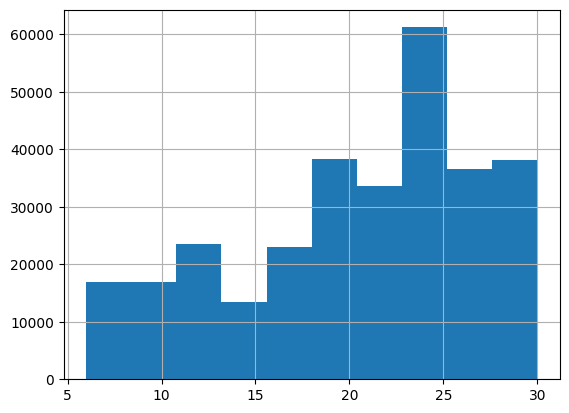

In [31]:
# distribution of age groups
ages = rand_dat_inc['target_child_age']
ages.hist()

In [32]:
age_counts = rand_dat_inc.groupby(['language','transcript_id','target_child_age']).nunique()
age_counts = age_counts.iloc[:, 0:2].reset_index()
age_counts['target_child_age'].mean()

age_counts=age_counts.merge(language_labels,on='language',how="right")

In [33]:
# what are the speaker roles in the transcripts? (pre cleaning)
rand_dat_inc["speaker_role"].unique()

array(['Target_Child', 'Mother', 'Relative', 'Father', 'Investigator',
       'Brother', 'Media', 'Visitor', 'Playmate', 'Friend', 'Grandmother',
       'Teenager', 'Unidentified', 'Sister', 'Adult', 'Environment',
       'Grandfather', 'Caretaker', 'Boy', 'Child', 'Girl', 'Target_Adult'],
      dtype=object)

In [34]:
child_dat = rand_dat_inc[rand_dat_inc["speaker_role"]=="Target_Child"]

In [35]:
# save only the target child speech to file
child_dat.to_csv("../data/child_dat.csv")

----
#### Geographic distribution

In [36]:
geo_dat = pd.read_csv("../data/langs_and_countries.csv",index_col=0)

In [37]:
# create language name column

geo_dat=geo_dat.rename(columns={"Language":"language"})

geo_dat=geo_dat.merge(language_labels,on='language',how="right")

In [38]:
%load_ext rpy2.ipython

In [39]:
%%R 

library("tidyverse")
library("cowplot")
library("repr")

theme_black = function(base_size = 11, base_family = "") {
 
  theme_grey(base_size = base_size, base_family = base_family) %+replace%
 
    theme(
      # Specify axis options
      axis.line = element_line(colour = "white"),  
      axis.text.x = element_text(color = "white",margin = margin(2, 2, 2, 2),size=8),  
      axis.text.y = element_text(color = "white",hjust=1,margin = margin(2, 2, 2, 2)),  
      axis.ticks = element_line(color = "white"),  
      axis.title.x = element_text(size = base_size, color = "white"),  
      axis.title.y = element_text(size = base_size, color = "white", angle = 90,margin = margin(0, 10, 0, 0)),  
      # Specify legend options
      legend.background = element_rect(color = NA, fill = "black"),  
      legend.key = element_rect(color = "white",  fill = "black"),  
      legend.key.size = unit(1.2, "lines"),  
      legend.key.height = NULL,  
      legend.key.width = NULL,      
      legend.text = element_text(size = base_size*0.8, color = "white"),  
      legend.title = element_text(size = base_size*0.8, face = "bold", hjust = 0, color = "white"),  
      legend.position = "right",  
      legend.text.align = NULL,  
      legend.title.align = NULL,  
      legend.direction = "vertical",  
      legend.box = NULL, 
      # Specify panel options
      panel.background = element_blank(),  
      panel.border = element_blank(),  
      panel.grid.major = element_blank(),  
      panel.grid.minor = element_blank(),  
#       panel.margin = unit(0.5, "lines"),   
      # Specify facetting options
      strip.background = element_rect(fill = "black", color = "white"),  
      strip.text.x = element_text( color = "white"),  
      strip.text.y = element_text(size = base_size*0.8, color = "white",angle = -90),  
      # Specify plot options
      plot.background = element_rect(color = "black", fill = "black"),  
      plot.title = element_text(size = base_size, color = "white"),  
      plot.margin = unit(rep(1, 4), "lines")
 
    )
 
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [40]:
%%R -i geo_dat

options(repr.plot.width=11.7, repr.plot.height=6.2)

geo_dat <- geo_dat %>%
    mutate(lang_fam_abbrv = recode(Language_Family,
                                   `Indo-European` = "I-E",
                                   `Uralic` = "U",
                                   `Japonic` = "J",
                                   `Koreanic` = "K",
                                   `Sino-Tibetan` = "S-T"),
           Language_label = Language_name,
           Language_label = paste0(Language_label," (",lang_fam_abbrv,")"))

mp <- NULL

mapWorld <- borders("world",
                    colour = "white",
#                     colour="gray50", # with white background
                    fill="gray75") # create a layer of borders

mp <- ggplot() + mapWorld

mp <- mp +
      geom_point(aes(x=geo_dat$longitude, y=geo_dat$latitude,color=geo_dat$Language_label), size=3) +
      # theme_black() +
      theme_void() +
      theme(text = element_text(size=16),
            #plot.background = element_rect(fill = "black"),
            legend.title = element_blank(),
            legend.position = c(0.91, 0.55),
            legend.background = element_rect(fill=alpha("white",0.90),
                                             size=0, linetype="dotted",
                                             colour = "white"),
            legend.text=element_text(size=16,colour="black"))

ggsave("../figures/geo_dat.pdf", width = 11.7, height = 6.2,dpi = 1200, scale = 1.2)
# ggsave("../figures/geo_dat_black.pdf", width = 11.7, height = 6.2,dpi = 1200)

In addition: Warning messages:
1: The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: Removed 1 rows containing missing values (`geom_point()`). 


----

#### Child age distribution

In [41]:
%%R -i age_counts

p <- ggplot(data=age_counts, aes(x = target_child_age, fill = Language_name)) +
     geom_histogram(binwidth=2.5) +
     facet_wrap(. ~ Language_name,ncol = 7) +
     theme_classic() + theme(text = element_text(size=16),
                             legend.title = element_blank(),
                             legend.background = element_rect(fill=alpha("white",0.90),
                                                            size=0, linetype="dotted",
                                                            colour = "white"),
                             legend.text=element_text(size=16)) +
     labs(x = "Child age (months)", y = "Freq")
    
     ggsave("../figures/age_hist.pdf", width = 11.7, height = 6.2)

In [42]:
rand_dat_inc_age = rand_dat_inc.groupby(['Language_name','transcript_id','target_child_id','target_child_age']).nunique().reset_index()
rand_dat_inc_age = rand_dat_inc_age[['Language_name','transcript_id','target_child_id','target_child_age']]

In [43]:
%%R -i rand_dat_inc_age

library('plotrix')
library('dplyr')

age_summary <- rand_dat_inc_age %>% group_by(Language_name) %>%
    summarise_all(funs(mean,std.error))
age_summary

# A tibble: 14 × 7
   Language_name transcript_id_mean target_child_id_mean target_child_age_mean
   <chr>                      <dbl>                <dbl>                 <dbl>
 1 Croatian                  29222.               18280.                  23.6
 2 English                   16683.                8523.                  17.6
 3 Estonian                  20280.               12790.                  23.7
 4 French                    45915.               24016.                  21.6
 5 German                    31008                19117.                  25.9
 6 Japanese                  21770.               13970.                  22.0
 7 Korean                    28157.               17372                   21.8
 8 Mandarin                  16830.               10061                   21.2
 9 Norwegian                 44957.               23625.                  16.9
10 Persian                   20942.               13594                   26.8
11 Polish                    4973

In addition: Warning message:
`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


In [44]:
%%R

library('ggplot2')


p <- ggplot(data=age_summary, aes(x = target_child_age_mean,
                                  y=Language_name, moe = target_child_age_std.error,
                                  color = Language_name)) +
     geom_point(aes(x = target_child_age_mean), size = 3) +
     geom_errorbarh(aes(xmin = target_child_age_mean - target_child_age_std.error,
                        xmax = target_child_age_mean + target_child_age_std.error), height = 0.5, size = 2) +
     theme_classic() + theme(text = element_text(size=16),
                             legend.title = element_blank(),
                             legend.background = element_rect(fill=alpha("white",0.90),
                                                            size=0, linetype="dotted",
                                                            colour = "white"),
                             legend.text=element_text(size=16)) +
     labs(x = "Child age (months)", y = "Language") +
     scale_y_discrete(limits=rev)
     ggsave("../figures/age_line.pdf", width = 11.7, height = 6.2)

In addition: Warning messages:
1: Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: Removed 1 rows containing missing values (`geom_errorbarh()`). 


----

#### Contingency assignment

Using a contingency window of 3 to start:

In [45]:
# .001 buffer time to ensure that caregiver utterances that begin at the same moment as infant vocalizations are not artificially counted as contingent

rand_dat_inc = contingent_extraction.assign_contingency(rand_dat_inc,3,.001) 

In [46]:
rand_dat_inc.to_csv("../data/rand_dat_inc_master.csv")

Number of contingent and non-contingent words (tokens)

In [47]:
rand_dat_inc = pd.read_csv("../data/rand_dat_inc_master.csv",index_col=0,low_memory=False)
rand_dat_inc=rand_dat_inc[rand_dat_inc["language"]!="ara"]
rand_dat_inc=rand_dat_inc[(rand_dat_inc["target_child_age"]>=5) & (rand_dat_inc["target_child_age"]<=30)]

rand_dat_inc_cg = rand_dat_inc[rand_dat_inc["caregiver"]=="caregiver"]

rand_dat_inc_cg["contingent"] = np.where(rand_dat_inc_cg["contingent"]==1, "contingent", "non-contingent")

rand_dat_inc_cg = rand_dat_inc_cg[rand_dat_inc_cg["gloss"].notna()]
rand_dat_inc_cg = rand_dat_inc_cg[rand_dat_inc_cg["gloss"]!="xxx"]
rand_dat_inc_cg = rand_dat_inc_cg[rand_dat_inc_cg["gloss"]!="yyy"]
rand_dat_inc_cg = rand_dat_inc_cg[rand_dat_inc_cg["gloss"]!="www"]

In [48]:
# how many contingent and non-contingent total words per language

contingent_noncontingent_counts = rand_dat_inc_cg.groupby(['language','contingent']).size().to_frame('count').reset_index()

print(contingent_noncontingent_counts.to_markdown())

|    | language   | contingent     |   count |
|---:|:-----------|:---------------|--------:|
|  0 | deu        | contingent     |    1716 |
|  1 | deu        | non-contingent |    2736 |
|  2 | eng        | contingent     |   17715 |
|  3 | eng        | non-contingent |   82344 |
|  4 | est        | contingent     |     940 |
|  5 | est        | non-contingent |    1538 |
|  6 | fas        | contingent     |     136 |
|  7 | fas        | non-contingent |     516 |
|  8 | fra        | contingent     |    5494 |
|  9 | fra        | non-contingent |   15684 |
| 10 | hrv        | contingent     |    2472 |
| 11 | hrv        | non-contingent |    3769 |
| 12 | jpn        | contingent     |    9877 |
| 13 | jpn        | non-contingent |   15247 |
| 14 | kor        | contingent     |    1554 |
| 15 | kor        | non-contingent |    3061 |
| 16 | nor        | contingent     |     735 |
| 17 | nor        | non-contingent |    1242 |
| 18 | pol        | contingent     |      23 |
| 19 | pol   

In [41]:
# average number of total contingent and non-contingent words per transcript across languages

contingent_noncontingent_count_avgs = rand_dat_inc_cg.groupby(['language','contingent','transcript_id']).size().to_frame('count').reset_index()

contingent_noncontingent_count_avgs =  contingent_noncontingent_count_avgs.rename({'count': 'counts'}, axis=1)

contingent_noncontingent_count_avgs = (contingent_noncontingent_count_avgs.groupby(["language","contingent"])
                                       .counts
                                       .agg(["mean"])
                                       .reset_index())

contingent_noncontingent_count_avgs =  contingent_noncontingent_count_avgs.rename({'mean': 'means'}, axis=1)

print(contingent_noncontingent_count_avgs.to_markdown())

|    | language   | contingent     |     means |
|---:|:-----------|:---------------|----------:|
|  0 | deu        | contingent     |  41.3158  |
|  1 | deu        | non-contingent |  69.5263  |
|  2 | eng        | contingent     |  17.2683  |
|  3 | eng        | non-contingent |  86.4679  |
|  4 | est        | contingent     |  29.2727  |
|  5 | est        | non-contingent |  60.7273  |
|  6 | fas        | contingent     |   6.45455 |
|  7 | fas        | non-contingent |  38.3636  |
|  8 | fra        | contingent     |  17.2952  |
|  9 | fra        | non-contingent |  54.3818  |
| 10 | hrv        | contingent     |  30.0517  |
| 11 | hrv        | non-contingent |  58.9483  |
| 12 | jpn        | contingent     |  53       |
| 13 | jpn        | non-contingent |  91.1625  |
| 14 | kor        | contingent     |  37.8571  |
| 15 | kor        | non-contingent |  95.7857  |
| 16 | nor        | contingent     |  24       |
| 17 | nor        | non-contingent |  50.4348  |
| 18 | pol        | 

Context proportions across languages

In [49]:
context_dat = pd.read_csv("../data/context_data.csv")
context_dat=context_dat.rename(columns={"Language":"Language_name"})
context_dat=context_dat.rename(columns={"Corpus":"corpus_name"})

In [50]:
rand_dat_inc=rand_dat_inc.merge(context_dat,on='corpus_name',how="right")

In [51]:
rand_dat_inc["Location"] = rand_dat_inc["Location"].fillna("NaN")
rand_dat_inc["Activity"] = rand_dat_inc["Activity"].fillna("NaN")

In [52]:
rand_dat_inc["context"] = rand_dat_inc["Location"] + rand_dat_inc["Activity"]

In [53]:
rand_dat_inc["context"].unique()

array(['LabUnstructured', 'OtherUnstructured', 'HomeUnstructured',
       'HomeOther', 'LabInterview/Unstructured', 'HomeNaN', 'NaNNaN',
       'HomeBook-reading', 'HomeInterview/Unstructured'], dtype=object)

In [54]:
rand_dat_inc=rand_dat_inc.rename(columns={"Language_name_x":"Language_name"})

In [55]:
# How many transcripts per corpora per different context

context_counts = rand_dat_inc.groupby(['Language_name','context','transcript_id']).nunique().reset_index()

In [56]:
count_table = context_counts.groupby(['Language_name','context']).size().to_frame('count').reset_index()

print(count_table.to_markdown())

|    | Language_name   | context                    |   count |
|---:|:----------------|:---------------------------|--------:|
|  0 | Croatian        | HomeUnstructured           |      58 |
|  1 | English         | HomeOther                  |      20 |
|  2 | English         | HomeUnstructured           |     340 |
|  3 | English         | LabInterview/Unstructured  |     368 |
|  4 | English         | LabUnstructured            |      26 |
|  5 | English         | OtherUnstructured          |     128 |
|  6 | Estonian        | HomeUnstructured           |      22 |
|  7 | French          | HomeUnstructured           |     238 |
|  8 | French          | NaNNaN                     |      41 |
|  9 | German          | HomeUnstructured           |      38 |
| 10 | Japanese        | HomeUnstructured           |     107 |
| 11 | Japanese        | NaNNaN                     |      53 |
| 12 | Korean          | HomeBook-reading           |      28 |
| 13 | Mandarin        | HomeUnstructure

In [57]:
count_table.to_csv("../data/context_counts_subject_level.csv")